<a href="https://colab.research.google.com/github/sheelvora/Projects/blob/master/World_Food_Facts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# World Food Facts

* Original Data Source:  https://www.kaggle.com/openfoodfacts/world-food-facts
* Modified Source:  https://www.kaggle.com/lwodarzek/nutrition-table-clustering/output

### Setup Tasks 

#### Install Latest Plotly

In [0]:
import plotly
plotly.__version__

'3.6.1'

In [0]:
!pip uninstall -q -y plotly
!pip install plotly==3.6.0

In [0]:
import plotly
plotly.__version__

'3.6.0'

In [0]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

In [0]:
!conda update --all
!pip uninstall -y numpy
!pip uninstall -y setuptools
!pip install setuptools==39.1.0
!pip install numpy

## Ingest

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator


In [0]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/noahgift/food/master/data/features.en.openfoodfacts.org.products.csv")
df.drop(["Unnamed: 0", "exceeded", "g_sum", "energy_100g"], axis=1, inplace=True) #drop two rows we don't need
df = df.drop(df.index[[1,11877]]) #drop outlier
df.rename(index=str, columns={"reconstructed_energy": "energy_100g"}, inplace=True)
df.head()

,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,product
0,28.57,64.29,14.29,3.57,0.00000,2267.85,Banana Chips Sweetened (Whole)
2,57.14,17.86,3.57,17.86,1.22428,2835.70,Organic Salted Nut Mix
3,18.75,57.81,15.62,14.06,0.13970,1953.04,Organic Muesli
4,36.67,36.67,3.33,16.67,1.60782,2336.91,Zen Party Mix
5,18.18,60.00,21.82,14.55,0.02286,1976.37,Cinnamon Nut Granola


In [0]:
#Maintain the original dataset features

df_original = df.copy()

## EDA

Rows and Attributes

In [0]:
df.shape

(45026, 7)

First 10 Columns

In [0]:
df.describe()

,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g
count,45026.000000,45026.000000,45026.000000,45026.000000,45026.000000,45026.000000
mean,10.765991,34.054064,16.005077,6.617261,1.469681,1111.286193
std,14.930295,29.557393,21.495731,7.926242,12.795225,791.608595
min,0.000000,0.000000,-1.200000,-3.570000,0.000000,0.000000
25%,0.000000,7.440000,1.570000,0.000000,0.063500,334.520000
50%,3.170000,22.390000,5.880000,4.000000,0.635000,1121.540000
75%,17.860000,61.540000,23.080000,9.520000,1.440180,1678.460000
max,100.000000,100.000000,100.000000,100.000000,2032.000000,4475.000000


## **Detecting Mistakes**

We calculate energy again by adding up the fat, carbohydrates and protein values by multiplying each of them with the energy contained in each of them per gram

1g fat = 37 kJ, 1g carbs and 1g protein = 17 kJ

We do this to check if some of the energy_100g entries were entered wrong or not and if the new variable could be an important feature in the cluster

In [0]:
df["reconstructed_energy"] = df["fat_100g"] * 37 + df["carbohydrates_100g"] * 17 + df["proteins_100g"] * 17

df.head(10)

,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,product,reconstructed_energy
0,28.57,64.29,14.29,3.57,0.00000,2267.85,Banana Chips Sweetened (Whole),2210.71
2,57.14,17.86,3.57,17.86,1.22428,2835.70,Organic Salted Nut Mix,2721.42
3,18.75,57.81,15.62,14.06,0.13970,1953.04,Organic Muesli,1915.54
4,36.67,36.67,3.33,16.67,1.60782,2336.91,Zen Party Mix,2263.57
5,18.18,60.00,21.82,14.55,0.02286,1976.37,Cinnamon Nut Granola,1940.01
6,60.71,17.86,3.57,14.29,0.01016,2914.24,Organic Hazelnuts,2792.82
7,5.95,66.67,2.38,16.67,0.02540,1648.83,Organic Oat Groats,1636.93
8,17.50,42.50,32.50,7.50,0.28448,1532.50,Energy Power Mix,1497.50
9,33.33,46.67,30.00,13.33,0.46482,2319.87,Antioxidant Mix - Berries & Chocolate,2253.21
10,10.91,69.09,27.27,10.91,0.02286,1785.49,Organic Quinoa Coconut Granola With Mango,1763.67


Text(0, 0.5, 'reconstructed energy')

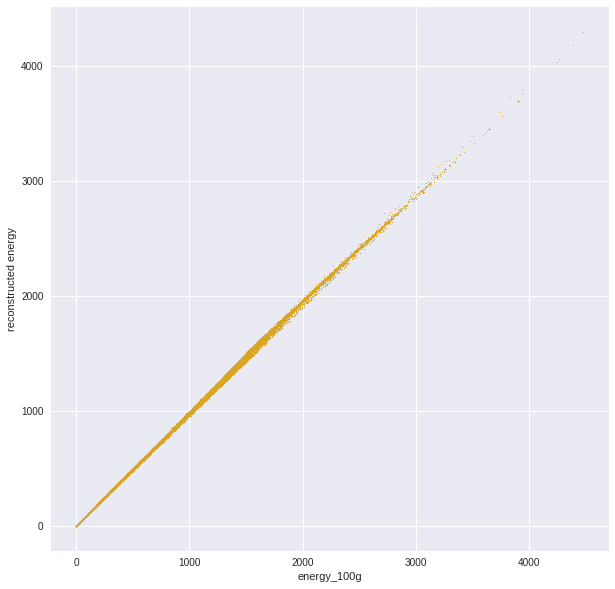

In [0]:
plt.figure(figsize = (10,10))
plt.scatter(df["energy_100g"], df["reconstructed_energy"], s = 0.6, c= "goldenrod")
plt.xlabel("energy_100g")
plt.ylabel("reconstructed energy")

Almost all values are close to each other baring some information that doesn't fit well

Another mistake to check is if the total sum of fat, carbohydrates and proteins exceed 100g since all values are per 100g so the total should not exceed 100g and if it does there is something wrong with the data entry

In [0]:
df["g_sum"] = df.fat_100g + df.carbohydrates_100g + df.proteins_100g

df["exceeded"] = np.where(df.g_sum.values > 100, 1, 0)

In [0]:
df[df["exceeded"] == 1].head()

,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,product,reconstructed_energy,g_sum,exceeded
94,39.29,80.36,46.43,5.36,0.63500,2989.55,Chocolate Scone,2910.97,125.01,1
220,0.00,100.00,60.00,5.00,0.25400,1785.00,"Fruit Ninja, Fruit Snacks, Original",1785.00,105.00,1
435,26.67,66.67,26.67,6.67,0.84582,2286.91,"Hello Panda, Choco Biscuits With Choco Cream, ...",2233.57,100.01,1
437,26.67,66.67,26.67,6.67,0.93218,2286.91,Biscuits With Strawberry Cream,2233.57,100.01,1
438,26.70,66.70,33.30,6.67,0.93100,2288.59,Hello Panda,2235.19,100.07,1


In [0]:
df.exceeded.value_counts() 

0    44633
1      393
Name: exceeded, dtype: int64

**Eliminate errors**



*   Features apart from the energy values having a negative or higher than 100g value
*   Energy amount of more than 3700 kJ (Highest a product can have; in our case 100% fat)



In [0]:
for col in df.columns:
    if col not in ["energy_100g", "product", "reconstructed_energy"]:
        df = df.loc[df[col] <= 100]
        df = df.loc[df[col] >= 0]

df = df.loc[df.energy_100g <= 3700]
df = df.loc[df.g_sum <= 100]

In [0]:
#Check the shape again

df.shape

(44571, 10)

## Visualizations

### Histogram

Generate distributions based on energy type

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



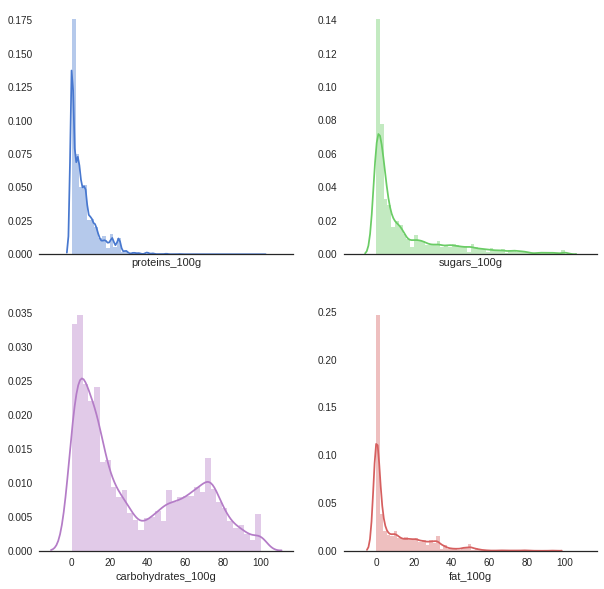

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
sns.set(style="white", palette="muted", color_codes=True)


# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(df.proteins_100g, color="b", ax=axes[0, 0])
sns.distplot(df.sugars_100g, color="g", ax=axes[0, 1])
sns.distplot(df.fat_100g, color="r", ax=axes[1, 1])
sns.distplot(df.carbohydrates_100g, color="m", ax=axes[1, 0])



*   Carbohydrates has the widest distribution with most products containing about 15g carbohydrates per 100g
*   
Occurence of fat in products stops at about 50g and for protein it stops at about 40g but they both peak at around 5g per 100g. This shows that people are not consuming protein rich products too often


*   Though the distribution of sugar keeps decreasing with increasing gram content but it is spreadout and it shows how much people consume products filled with sugar





### Word Cloud

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#### High protein foods

Find protein foods in the 98th percentile

In [0]:
high_protein_df = df[df.proteins_100g > df.proteins_100g.quantile(.98)]
high_protein_text = high_protein_df['product'].values
len(high_protein_text)

896

Word Cloud High Protein

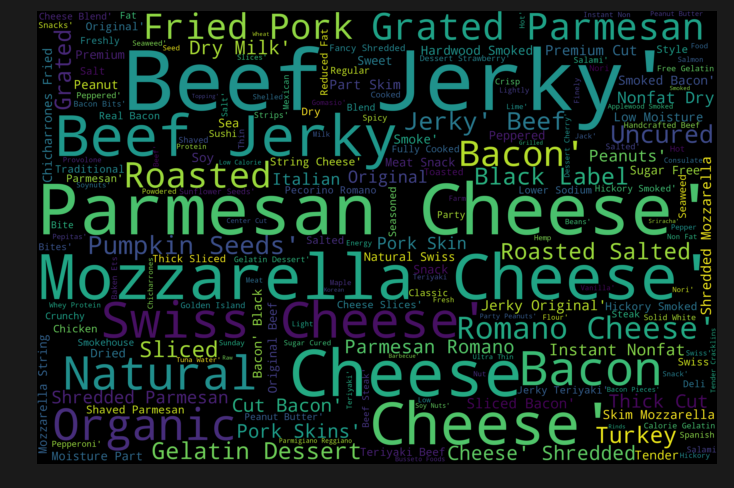

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(high_protein_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### High fat foods

Find fatty foods in the 98th percentile

In [0]:
high_fat_df = df[df.fat_100g > df.fat_100g.quantile(.98)]
high_fat_text = high_fat_df['product'].values
len(high_fat_text)

878

Word Cloud High Fat

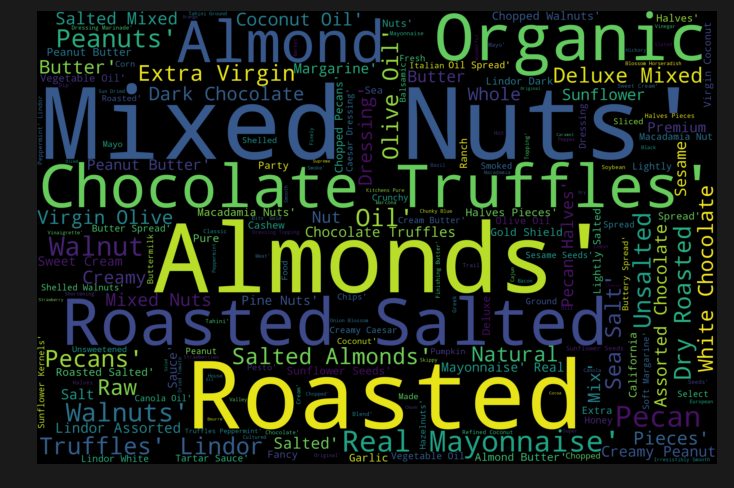

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(high_fat_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### High sugar foods

Find sugary foods in the 98th percentile

In [0]:
high_sugar_df = df[df.sugars_100g > df.sugars_100g.quantile(.98)]
high_sugar_text = high_sugar_df['product'].values
len(high_sugar_text)

893

Word Cloud High Sugar

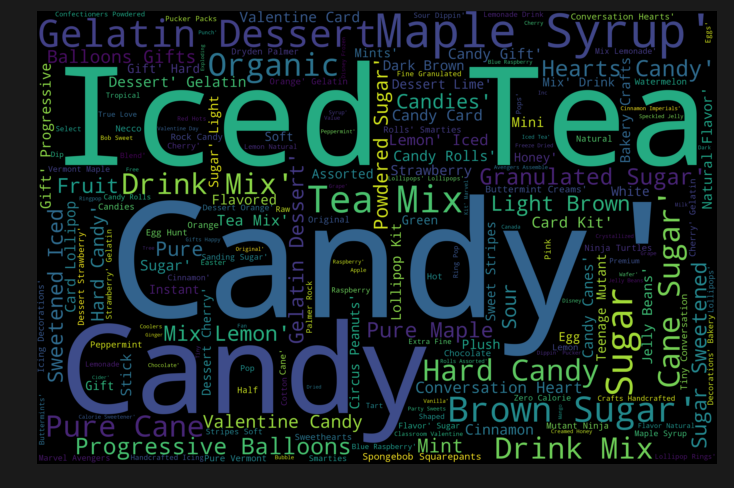

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(high_sugar_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Clustering

In [0]:
df.columns

Index(['fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g',
       'salt_100g', 'energy_100g', 'product', 'reconstructed_energy', 'g_sum',
       'exceeded'],
      dtype='object')

In [0]:
df.drop("exceeded", axis=1, inplace=True)

### Create Features to Cluster

In [0]:
df_cluster_features = df.drop("product", axis=1)

In [0]:
df_cluster_features.head(10)

,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum
0,28.57,64.29,14.29,3.57,0.00000,2267.85,2210.71,96.43
2,57.14,17.86,3.57,17.86,1.22428,2835.70,2721.42,92.86
3,18.75,57.81,15.62,14.06,0.13970,1953.04,1915.54,90.62
4,36.67,36.67,3.33,16.67,1.60782,2336.91,2263.57,90.01
5,18.18,60.00,21.82,14.55,0.02286,1976.37,1940.01,92.73
6,60.71,17.86,3.57,14.29,0.01016,2914.24,2792.82,92.86
7,5.95,66.67,2.38,16.67,0.02540,1648.83,1636.93,89.29
8,17.50,42.50,32.50,7.50,0.28448,1532.50,1497.50,67.50
9,33.33,46.67,30.00,13.33,0.46482,2319.87,2253.21,93.33
10,10.91,69.09,27.27,10.91,0.02286,1785.49,1763.67,90.91


### Scale the data

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(scaler.fit(df_cluster_features))
print(scaler.transform(df_cluster_features))

MinMaxScaler(copy=True, feature_range=(0, 1))
[[0.30611808 0.6429     0.1429     ... 0.62305797 0.64018985 0.9643    ]
 [0.61223615 0.1786     0.0357     ... 0.77906629 0.78808413 0.9286    ]
 [0.20090003 0.5781     0.1562     ... 0.53656861 0.55471286 0.9062    ]
 ...
 [0.         0.1333     0.1333     ... 0.06225772 0.065623   0.1333    ]
 [0.         0.1625     0.1625     ... 0.07589557 0.07999803 0.1625    ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


#### Cluster Diagnostics

In [0]:
X_train = df_cluster_features.values

model = GaussianMixture(n_components=14, covariance_type="full", n_init = 5, max_iter = 200)
model.fit(X_train)
log_prob = model.score_samples(X_train)
results = df_cluster_features.copy()
results["cluster"] = model.predict(X_train)
results["product"] = df_original.loc[df.index.values, "product"]

probas = np.round(model.predict_proba(X_train), 2)
cluster_values = results.cluster.values
certainty = np.zeros(cluster_values.shape[0])
for n in range(len(certainty)):
    certainty[n] = probas[n,cluster_values[n]]
    
results["certainty"] = certainty

In [0]:
print(log_prob)

[-5.02925014 -2.37060745 -6.74878901 ... 12.76132126 12.10739469
 12.26714802]


In [0]:
results[results.cluster == 4].head(10)

,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum,cluster,product,certainty
106,71.43,0.00,0.00,0.0,1.81356,2785.77,2642.91,71.43,4,Original Buttery Spread,0.97
367,92.00,0.50,0.50,0.5,0.01000,3605.00,3421.00,93.00,4,Sunflower oil,1.00
586,82.00,0.40,0.40,0.4,0.03000,3211.60,3047.60,82.80,4,Beurre doux,1.00
987,73.33,13.33,3.33,10.0,0.00000,3256.48,3109.82,96.66,4,"Of California, Pecans",0.95
989,73.33,13.33,3.33,10.0,0.00000,3256.48,3109.82,96.66,4,Pecans,0.95
1009,73.33,13.33,3.33,10.0,0.00000,3256.48,3109.82,96.66,4,Premium Pecan Halves,0.95
1010,73.33,13.33,3.33,10.0,0.00000,3256.48,3109.82,96.66,4,"Of California, Pecan Halves",0.95
1011,73.33,13.33,3.33,10.0,0.00000,3256.48,3109.82,96.66,4,Chopped Pecans,0.95
1015,73.33,13.33,3.33,10.0,0.00000,3256.48,3109.82,96.66,4,"Pecans, Chopped",0.95
1016,73.33,13.33,3.33,10.0,0.00000,3256.48,3109.82,96.66,4,Pecan Halves,0.95


## **Anomaly Detection**

Choosing an outlier threshold

We set the value to tell the model by how much is the affected data has to differ from the normal data so we choose the value of 12% as our threshold as that is the value at which log probability falls sharply

In [0]:
def get_outliers(log_prob, threshold):
    epsilon = np.quantile(log_prob, threshold)
    outliners = np.where(log_prob <= epsilon, 1, 0)
    return outliners 

In [0]:
choice = 0.12

We can check if the product is an outlier if the value of the feature 'anomaly' is 1

In [0]:
results["anomaly"] = get_outliers(log_prob, choice)
results.head()

,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum,cluster,product,certainty,anomaly
0,28.57,64.29,14.29,3.57,0.00000,2267.85,2210.71,96.43,13,Banana Chips Sweetened (Whole),0.98,1
2,57.14,17.86,3.57,17.86,1.22428,2835.70,2721.42,92.86,0,Organic Salted Nut Mix,0.92,0
3,18.75,57.81,15.62,14.06,0.13970,1953.04,1915.54,90.62,13,Organic Muesli,0.70,1
4,36.67,36.67,3.33,16.67,1.60782,2336.91,2263.57,90.01,0,Zen Party Mix,1.00,0
5,18.18,60.00,21.82,14.55,0.02286,1976.37,1940.01,92.73,10,Cinnamon Nut Granola,0.64,1


In [0]:
features = ["energy_100g", "reconstructed_energy"]

Text(0, 0.5, 'reconstructed_energy')

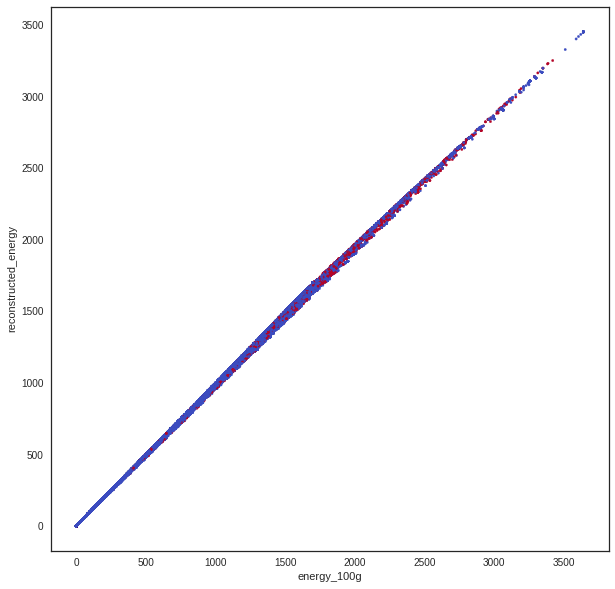

In [0]:
plt.figure(figsize = (10,10))
plt.scatter(results[features[0]], results[features[1]], c=results.anomaly.values, cmap = "coolwarm", s = 5.5)
plt.xlabel(features[0])
plt.ylabel(features[1])

Outliers are marked red in colour

In [0]:
results[results.anomaly == 1].head(25)

,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum,cluster,product,certainty,anomaly
0,28.57,64.29,14.29,3.57,0.00000,2267.85,2210.71,96.43,13,Banana Chips Sweetened (Whole),0.98,1
3,18.75,57.81,15.62,14.06,0.13970,1953.04,1915.54,90.62,13,Organic Muesli,0.70,1
5,18.18,60.00,21.82,14.55,0.02286,1976.37,1940.01,92.73,10,Cinnamon Nut Granola,0.64,1
8,17.50,42.50,32.50,7.50,0.28448,1532.50,1497.50,67.50,3,Energy Power Mix,0.97,1
10,10.91,69.09,27.27,10.91,0.02286,1785.49,1763.67,90.91,13,Organic Quinoa Coconut Granola With Mango,0.98,1
11,50.00,23.33,6.67,6.67,1.27000,2460.00,2360.00,80.00,0,Fire Roasted Hatch Green Chile Almonds,0.63,1
13,22.22,57.41,5.56,12.96,0.28194,2062.87,2018.43,92.59,0,Organic Unswt Berry Coconut Granola,0.80,1
17,6.67,64.44,11.11,13.33,0.01016,1582.22,1568.88,84.44,2,Organic Red Quinoa,0.77,1
20,9.09,70.91,29.09,10.91,0.04572,1745.45,1727.27,90.91,13,Organic Blueberry Almond Granola,0.98,1
21,65.00,24.00,7.00,6.00,0.09398,3045.00,2915.00,95.00,0,Organic Coconut Chips,0.98,1


From this table we can observe that most of the outliers are products that are considered healthy, organic and nutritious like products containing nuts, granola, almonds, fruits etc. That could come from the fact that such natural products often don't have completed nutrition tables or no nutrition-tables at all because these natural products vary so much in their nutrition.